In [ ]:
# Cell 1: installs and imports
!pip install torch torchvision timm scikit-image --quiet

import os, random, math, glob, csv, time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# For slightly more stable training
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


Device: cuda


In [ ]:
# Cell 2: Dataset - create true LR (hr_size//scale) and HR (hr_size)

from google.colab import drive
drive.mount('/content/drive')

from glob import glob

class MoonSRDataset(Dataset):
    def __init__(self, folder, hr_size=128, scale=5, augment=False):
        exts = ("*.png","*.jpg","*.jpeg","*.tif","*.tiff")
        files=[]
        for e in exts:
            files += glob(os.path.join(folder, e))
        files = sorted(files)
        if len(files)==0:
            raise ValueError(f"No images found in {folder}")
        self.files = files
        self.hr_size = hr_size
        self.scale = scale
        self.lr_size = hr_size // scale
        self.augment = augment
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        w,h = img.size

        # If image is smaller than hr_size, upscale first
        if w < self.hr_size or h < self.hr_size:
            img = img.resize((max(self.hr_size,w), max(self.hr_size,h)), Image.BICUBIC)
            w,h = img.size

        # random crop hr patch
        x = random.randint(0, w - self.hr_size)
        y = random.randint(0, h - self.hr_size)
        hr = img.crop((x,y,x+self.hr_size, y+self.hr_size))

        # simple horizontal flip
        if self.augment and random.random() < 0.5:
            hr = hr.transpose(Image.FLIP_LEFT_RIGHT)

        # LR is downsampled HR (true LR)
        lr = hr.resize((self.lr_size, self.lr_size), Image.BICUBIC)
        # upsample LR back to HR size (input to SRCNN)
        lr_up = lr.resize((self.hr_size, self.hr_size), Image.BICUBIC)

        return self.to_tensor(lr_up), self.to_tensor(hr)

# =======================
# SET YOUR FOLDERS HERE
# =======================
train_dir = "/content/drive/MyDrive/Moon Kaggle Images/Training"   # <-- change to your 8500-image folder
val_dir   = "/content/drive/MyDrive/Moon Kaggle Images/Testing"    # <-- change to your test/val folder

hr_size   = 128
scale     = 5

# Smaller batch size to avoid OOM with big dataset
batch_size  = 4
num_workers = 2

pin_mem = True if device.type == "cuda" else False

train_ds = MoonSRDataset(train_dir, hr_size=hr_size, scale=scale, augment=True)
val_ds   = MoonSRDataset(val_dir,   hr_size=hr_size, scale=scale, augment=False)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_mem,
    persistent_workers=(num_workers > 0)
)

val_loader   = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=pin_mem,
    persistent_workers=False
)

print("Train images:", len(train_ds), "Val images:", len(val_ds))
print("HR size:", hr_size, "LR size:", hr_size//scale, "scale:", scale)
print("Batch size:", batch_size)


Mounted at /content/drive
Train images: 8856 Val images: 4
HR size: 128 LR size: 25 scale: 5
Batch size: 4


In [ ]:
# Cell 3: SRCNN model (same architecture)

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x

model = SRCNN().to(device)
print("Model params:", sum(p.numel() for p in model.parameters()))


Model params: 69251


In [ ]:
# Cell 4: optimizer, loss, scheduler, scaler

criterion = nn.MSELoss()       # MSE aligns with PSNR
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
scaler = GradScaler()


/tmp/ipython-input-3672066288.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Cell 5: Training loop - safe for big dataset

epochs = 10                  # you can increase later if it runs fine
ckpt_dir = "/content/srcnn_checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
best_psnr = -1.0

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    steps = 0

    for lr_imgs, hr_imgs in train_loader:
        lr_imgs = lr_imgs.to(device, non_blocking=True)
        hr_imgs = hr_imgs.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        try:
            with autocast():
                sr = model(lr_imgs)
                loss = criterion(sr, hr_imgs)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            steps += 1

        except RuntimeError as e:
            # Protect from CUDA out-of-memory crash
            if "out of memory" in str(e):
                print("⚠️ CUDA OOM in this batch, skipping it...")
                if device.type == "cuda":
                    torch.cuda.empty_cache()
                continue
            else:
                raise e

    scheduler.step()
    train_loss = running_loss / max(1, steps)

    # ===== Validation: compute PSNR & SSIM =====
    model.eval()
    psnrs=[]; ssims=[]
    with torch.no_grad():
        for vlr, vhr in val_loader:
            vlr = vlr.to(device, non_blocking=True)
            vhr = vhr.to(device, non_blocking=True)
            out = model(vlr)

            # convert to uint8 [0,255]
            out_np = out.detach().cpu().permute(0,2,3,1).numpy() * 255.0
            hr_np  = vhr.detach().cpu().permute(0,2,3,1).numpy() * 255.0

            out_np = np.clip(out_np, 0, 255).astype(np.uint8)
            hr_np  = np.clip(hr_np, 0, 255).astype(np.uint8)

            for i in range(out_np.shape[0]):
                try:
                    p = compare_psnr(hr_np[i], out_np[i], data_range=255)
                except:
                    p = compare_psnr(hr_np[i][...,0], out_np[i][...,0], data_range=255)
                try:
                    s = compare_ssim(hr_np[i], out_np[i], data_range=255, channel_axis=2)
                except TypeError:
                    s = compare_ssim(hr_np[i], out_np[i], data_range=255, multichannel=True)
                psnrs.append(p); ssims.append(s)

    mean_psnr = float(np.mean(psnrs)) if len(psnrs) else float('nan')
    mean_ssim = float(np.mean(ssims)) if len(ssims) else float('nan')

    # Save best model by PSNR
    if not math.isnan(mean_psnr) and mean_psnr > best_psnr:
        best_psnr = mean_psnr
        torch.save(model.state_dict(), os.path.join(ckpt_dir, "best_srcnn.pth"))

    print(f"Epoch {epoch}/{epochs} | "
          f"TrainLoss: {train_loss:.6f} | "
          f"Val PSNR: {mean_psnr:.3f} dB | "
          f"Val SSIM: {mean_ssim:.4f} | "
          f"Best PSNR: {best_psnr:.3f}")


/tmp/ipython-input-2235032502.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10 | TrainLoss: 0.001076 | Val PSNR: 29.338 dB | Val SSIM: 0.6964 | Best PSNR: 29.338
Epoch 2/10 | TrainLoss: 0.000745 | Val PSNR: 32.207 dB | Val SSIM: 0.7673 | Best PSNR: 32.207
Epoch 3/10 | TrainLoss: 0.000713 | Val PSNR: 30.117 dB | Val SSIM: 0.7322 | Best PSNR: 32.207
Epoch 4/10 | TrainLoss: 0.000699 | Val PSNR: 28.783 dB | Val SSIM: 0.7126 | Best PSNR: 32.207
Epoch 5/10 | TrainLoss: 0.000679 | Val PSNR: 29.686 dB | Val SSIM: 0.7473 | Best PSNR: 32.207
Epoch 6/10 | TrainLoss: 0.000675 | Val PSNR: 28.432 dB | Val SSIM: 0.6923 | Best PSNR: 32.207
Epoch 7/10 | TrainLoss: 0.000676 | Val PSNR: 28.888 dB | Val SSIM: 0.7489 | Best PSNR: 32.207
Epoch 8/10 | TrainLoss: 0.000659 | Val PSNR: 28.261 dB | Val SSIM: 0.7032 | Best PSNR: 32.207
Epoch 9/10 | TrainLoss: 0.000658 | Val PSNR: 30.913 dB | Val SSIM: 0.7751 | Best PSNR: 32.207
Epoch 10/10 | TrainLoss: 0.000651 | Val PSNR: 29.780 dB | Val SSIM: 0.7355 | Best PSNR: 32.207


In [ ]:
# Cell 7: Generate hazard maps and annotated images (uses generate_hazard_map_from_array from your file)
# If your file already defines generate_hazard_map_from_array, use it. Otherwise use the function below.
import cv2
# reusing function from your uploaded file (if present)
try:
    generate_hazard_map_from_array
except NameError:
    # minimal fallback hazard generator (same idea as your file)
    def generate_hazard_map_from_array(sr_img_rgb, gauss_ksize=3):

        gray = cv2.cvtColor(sr_img_rgb, cv2.COLOR_RGB2GRAY)
        gray_blur = cv2.GaussianBlur(gray, (gauss_ksize,gauss_ksize), 0)
        sobelx = cv2.Sobel(gray_blur, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_blur, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.hypot(sobelx, sobely)
        lap = cv2.Laplacian(gray_blur, cv2.CV_64F)
        hazard = np.abs(sobel) + np.abs(lap)
        mn, mx = hazard.min(), hazard.max()
        if mx>mn:
            hazard = (hazard-mn) / (mx-mn)
        else:
            hazard = np.zeros_like(hazard)
        return hazard.astype(np.float32)

os.makedirs("Results_Hazard", exist_ok=True)
os.makedirs("Results_Annotated", exist_ok=True)

from PIL import Image
files = sorted([f for f in os.listdir("Results_SR") if f.lower().endswith((".png",".jpg",".jpeg"))])
for i,fname in enumerate(files):
    sr_path = os.path.join("Results_SR", fname)
    sr = np.array(Image.open(sr_path).convert("RGB"))
    hazard = generate_hazard_map_from_array(sr, gauss_ksize=3)
    hz_u8 = (np.clip(hazard,0,1)*255).astype(np.uint8)
    cv2.imwrite(os.path.join("Results_Hazard", f"haz_{i}.png"), hz_u8)
    # simple threshold -> mask -> annotate
    th = (hazard > np.percentile(hazard, 90)).astype(np.uint8)
    # find contours and draw boxes

    mask = (th*255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ann = cv2.cvtColor(sr.copy(), cv2.COLOR_RGB2BGR)
    count = 0
    for c in contours:
        a = cv2.contourArea(c)
        if a < 50:
            continue
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(ann, (x,y), (x+w,y+h), (0,0,255), 2)
        count += 1
    Image.fromarray(cv2.cvtColor(ann, cv2.COLOR_BGR2RGB)).save(os.path.join("Results_Annotated", f"ann_{i}.png"))
    print(f"{fname}: hazards={count} saved annotated -> Results_Annotated/ann_{i}.png")

sr_0_download (1).png: hazards=330 saved annotated -> Results_Annotated/ann_0.png
sr_1_download (2).png: hazards=545 saved annotated -> Results_Annotated/ann_1.png
sr_2_download (3).png: hazards=316 saved annotated -> Results_Annotated/ann_2.png
sr_3_download.png: hazards=504 saved annotated -> Results_Annotated/ann_3.png


Using lander radius (with 10% margin): 1.10 m
meters_per_pixel = 0.05 m/px -> required landing radius = 22 px

Example conversions (meters_per_pixel -> required_radius_px):
   0.005 m/px  ->   220 px  (i.e. 1.10 m)
   0.010 m/px  ->   110 px  (i.e. 1.10 m)
   0.020 m/px  ->    55 px  (i.e. 1.10 m)
   0.050 m/px  ->    22 px  (i.e. 1.10 m)
   0.100 m/px  ->    11 px  (i.e. 1.10 m)


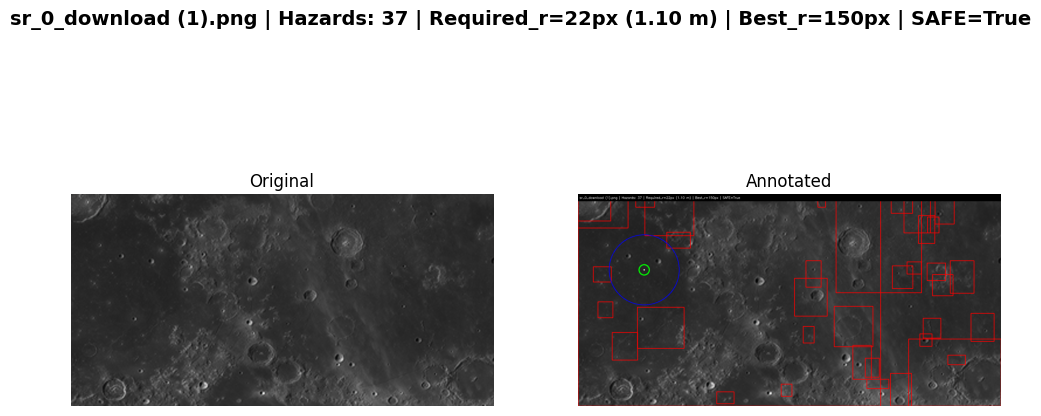

sr_0_download (1).png | Hazards: 37 | Required_r=22px (1.10 m) | Best_r=150px | SAFE=True


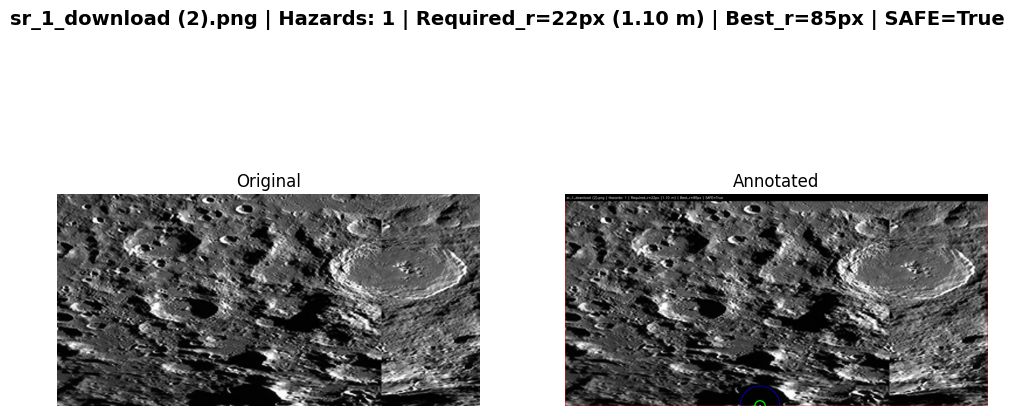

sr_1_download (2).png | Hazards: 1 | Required_r=22px (1.10 m) | Best_r=85px | SAFE=True


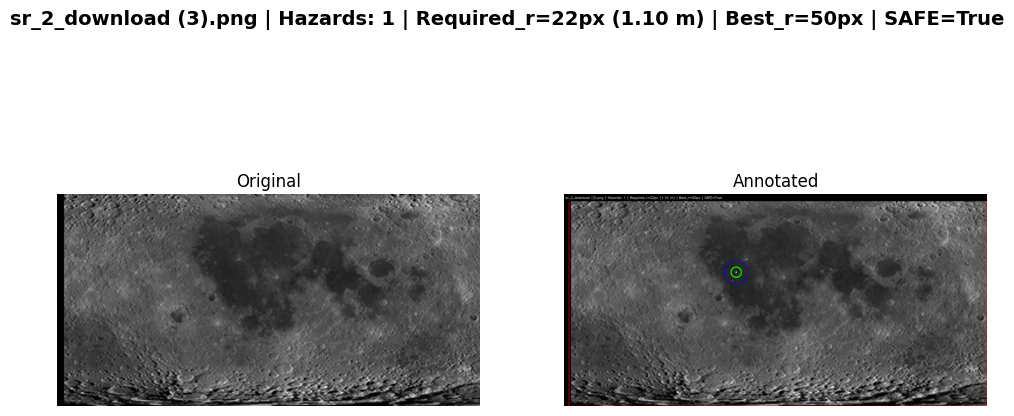

sr_2_download (3).png | Hazards: 1 | Required_r=22px (1.10 m) | Best_r=50px | SAFE=True


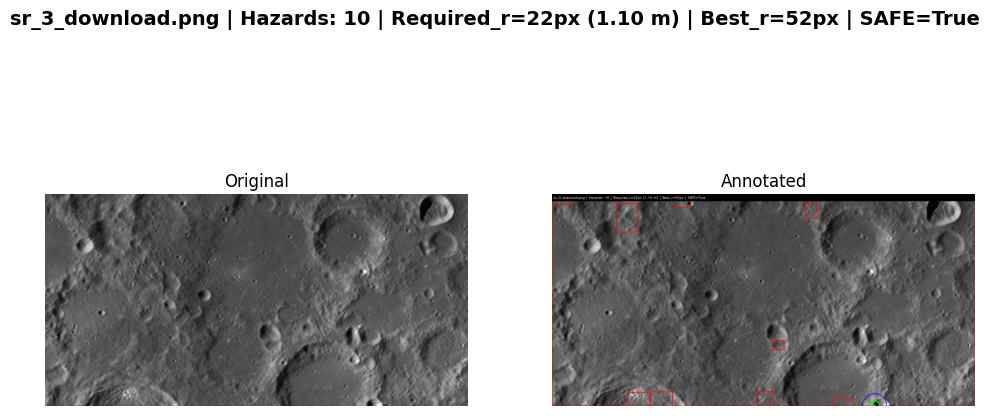

sr_3_download.png | Hazards: 10 | Required_r=22px (1.10 m) | Best_r=52px | SAFE=True


In [ ]:
# Colab cell: Use Chandrayaan-3 lander size -> compute required pixel radius -> show annotated outputs
# (Paste & run in Colab. Edit meters_per_pixel to the correct value for your SR images.)

import os, cv2, numpy as np, matplotlib.pyplot as plt
from skimage import morphology, exposure

# ----------------- SETTINGS (edit meters_per_pixel to match your SR image) -----------------
# Chandrayaan-3 Vikram lander footprint: ~2000 x 2000 x 1166 mm -> use diameter = 2.0 m
lander_diameter_m = 2.0                # (source: ISRO / EOportal). :contentReference[oaicite:1]{index=1}
safety_margin = 1.10                   # 10% extra margin
lander_radius_m = (lander_diameter_m / 2.0) * safety_margin   # -> 1.1 m
# Set meters_per_pixel for your SR images here:
meters_per_pixel = 0.05   # <-- CHANGE THIS to your true scale (meters / pixel)
# If you don't know it, try sample values below in the table printed.
# ------------------------------------------------------------------------------------------

required_radius_px = int(round(lander_radius_m / meters_per_pixel))
print(f"Using lander radius (with 10% margin): {lander_radius_m:.2f} m")
print(f"meters_per_pixel = {meters_per_pixel} m/px -> required landing radius = {required_radius_px} px")

# show example conversions for quick guidance
example_scales = [0.005, 0.01, 0.02, 0.05, 0.1]  # m/px
print("\nExample conversions (meters_per_pixel -> required_radius_px):")
for s in example_scales:
    px = int(round(lander_radius_m / s))
    print(f"  {s:6.3f} m/px  ->  {px:4d} px  (i.e. {px * s:.2f} m)")

# ----------------- detection parameters (same pipeline as before) -----------------
sr_folder = "Results_SR"    # folder with SRCNN SR images
min_hazard_area = 800
# Hough / detection parameters (tweak if needed)
hough_dp = 1.2; hough_minDist = 30; hough_param1 = 100; hough_param2 = 60
hough_minRadius = 10; hough_maxRadius = 60
hough_overlap_iou_thresh = 0.12; border_ignore = 6
# ------------------------------------------------------------------------------------

def detect_hazards(img_bgr):
    h,w = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_eq = exposure.equalize_adapthist(gray, clip_limit=0.03)
    gray_eq = (gray_eq * 255).astype(np.uint8)
    blur = cv2.GaussianBlur(gray_eq, (5,5), 0)

    # contour-based detection
    th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 31, 9)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    th_closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    th_bool = th_closed.astype(bool)
    th_clean = morphology.remove_small_objects(th_bool, min_size=min_hazard_area)
    mask_contour = (th_clean.astype('uint8') * 255)

    # Hough rim detection (filtered)
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=hough_dp, minDist=hough_minDist,
                               param1=hough_param1, param2=hough_param2,
                               minRadius=hough_minRadius, maxRadius=hough_maxRadius)
    mask_hough = np.zeros((h,w), dtype=np.uint8)
    if circles is not None:
        circles = np.round(circles[0,:]).astype(int)
        for (cx,cy,r) in circles:
            if r < hough_minRadius or r > hough_maxRadius: continue
            if cx < border_ignore or cy < border_ignore or cx > w-border_ignore or cy > h-border_ignore:
                continue
            circ_mask = np.zeros((h,w), dtype=np.uint8)
            cv2.circle(circ_mask, (cx,cy), max(1, r-2), 255, -1)
            inter = np.logical_and(circ_mask>0, mask_contour>0).sum()
            circ_area = circ_mask.sum() / 255.0
            if circ_area > 0 and (inter / circ_area) >= hough_overlap_iou_thresh:
                cv2.circle(mask_hough, (cx,cy), max(1, r-2), 255, -1)

    combined = cv2.bitwise_or(mask_contour, mask_hough)
    combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=1)
    combined_bool = combined.astype(bool)
    final_mask = (morphology.remove_small_objects(combined_bool, min_size=min_hazard_area).astype('uint8') * 255)
    return final_mask

def find_best_landing(mask, required_r_px):
    h,w = mask.shape[:2]
    if np.sum(mask) == 0:
        return h//2, w//2, min(h//2, w//2), True
    free = (mask == 0).astype(np.uint8)
    dist = cv2.distanceTransform(free, cv2.DIST_L2, 5)
    ys, xs = np.where(dist >= required_r_px)
    if len(ys) > 0:
        # pick candidate with maximum margin
        idx = np.argmax(dist[ys, xs])
        cy, cx = int(ys[idx]), int(xs[idx])
        return cy, cx, int(dist[cy, cx]), True
    # none fits exactly -> return global max (unsafe)
    _, maxVal, _, maxLoc = cv2.minMaxLoc(dist)
    cy, cx = int(maxLoc[1]), int(maxLoc[0])
    best_r = int(maxVal)
    best_r = max(1, min(best_r, min(h//2, w//2)))
    return cy, cx, best_r, False

def show_pair(orig, ann, header):
    plt.figure(figsize=(12,6))
    plt.suptitle(header, fontsize=14, fontweight='bold')
    plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(ann); plt.title("Annotated"); plt.axis('off')
    plt.show()

# PROCESS images in Results_SR and display in Colab
sr_files = sorted([f for f in os.listdir("Results_SR") if f.lower().endswith((".png",".jpg",".jpeg"))])
if len(sr_files) == 0:
    print("No SR images found in folder 'Results_SR'. Run SRCNN eval cell first.")
else:
    for fname in sr_files:
        path = os.path.join("Results_SR", fname)
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            print("Cannot read", path); continue
        h,w = img_bgr.shape[:2]

        mask = detect_hazards(img_bgr)
        contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        hazard_count = sum(1 for c in contours if cv2.contourArea(c) >= min_hazard_area)

        cy, cx, best_r_px, is_safe = find_best_landing(mask, required_radius_px)

        # annotate
        out = img_bgr.copy()
        for c in contours:
            if cv2.contourArea(c) < min_hazard_area: continue
            x,y,ww,hh = cv2.boundingRect(c)
            cv2.rectangle(out, (x,y), (x+ww, y+hh), (0,0,255), 2)

        br = int(max(1, min(best_r_px, min(h//2, w//2))))
        req_color = (0,255,0) if is_safe else (0,0,255)

        cv2.circle(out, (cx,cy), br, (255,0,0), 2)                 # maximal fit
        cv2.circle(out, (cx,cy), required_radius_px, req_color, 3) # required lander radius (pixels)
        cv2.circle(out, (cx,cy), 3, (255,255,255), -1)

        # header written on image
        header = f"{fname} | Hazards: {hazard_count} | Required_r={required_radius_px}px ({lander_radius_m:.2f} m) | Best_r={br}px | SAFE={is_safe}"
        cv2.rectangle(out, (0,0), (w, 30), (0,0,0), -1)
        cv2.putText(out, header, (6,20), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,255,255), 1, cv2.LINE_AA)

        show_pair(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), cv2.cvtColor(out, cv2.COLOR_BGR2RGB), header)
        print(header)
